# Import

In [1]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import plotly
plotly.offline.init_notebook_mode()

from file_py.attack_log_unification import AttackLogUnification
from file_py.run_log_parser import RunLogParser
from file_py.csv_preprocessing_scaler import CsvPreprocessingScaler

from file_py.plots import Plots

from file_py.utils import MarkdownHelper

from file_py.stat_severity import StatSeverity
from file_py.attack_pattern_analyzer import AttackPatternAnalyzer
from file_py.signatures_patterns import SignaturePatterns

from file_py.signature_stats_calculator import SignatureStatsCalculator
from file_py.sigma_rule_analysis import SigmaRuleAnalysis

from file_py.plots_single_attack import PlotsSingleAttack

from file_py.correlation_matrix_plots import CorrelationMatrixPlots

# CARICAMENTO FILE

Sostituire il percorso dei file attuali con il percorso dei file di interesse qui:

In [2]:
# FILE CONTENENTE I LOG
df = CsvPreprocessingScaler.read_csv_file("file_csv/LogSplunkWF_29_07.csv")

# FILE CON LE DATE DI INIZIO E FINE DEGLI ATTACCHI
files = ['file_csv/attackLog_29_07_1attack.csv', 'file_csv/attackLog_29_07_2attack.csv']

# Preprocessing

In [3]:
df_raw = CsvPreprocessingScaler.RawPreprocessing(df)
df_Le = CsvPreprocessingScaler.LEPreprocessing(df)
df_std_LE = CsvPreprocessingScaler.stdScaler(CsvPreprocessingScaler.LEPreprocessing(df))

In [4]:
attack_log_path = AttackLogUnification.attack_log_together(files,'file_csv/attackLog_29_07_comlbined.csv')

In [5]:
result_df_Le = RunLogParser.process_attacks(attack_log_path, CsvPreprocessingScaler.stdScaler(CsvPreprocessingScaler.LEPreprocessing(df)))
result_df_Raw = RunLogParser.process_attacks(attack_log_path, CsvPreprocessingScaler.RawPreprocessing(df))

# Graphic Analysis of Attacks

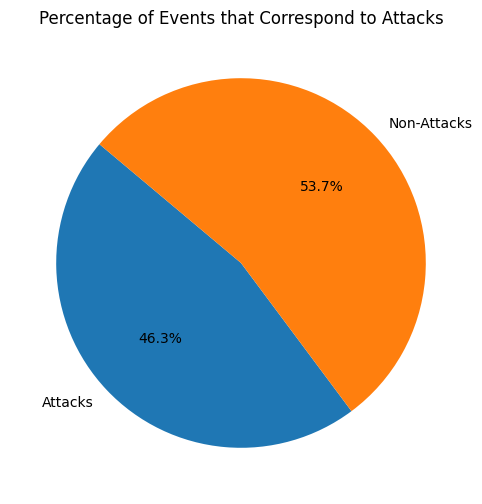

In [6]:
Plots.plot_cake_attack(result_df_Raw)

In [7]:
Plots.plot_top_10_signatures(result_df_Raw)

alt.VConcatChart(...)

Qui si può notare come generalmente le __regole scattate più volte__ sono anche quelle che hanno effettivamente __risposto a più attachi__ e che sono **scattate a vuoto più volte**.  

In [8]:
Plots.plot_precision_recall(result_df_Raw)

alt.VConcatChart(...)

Il *primo grafico* mostra la **precisione** di ciascuna regola, cioè la proporzione di **attivazioni corrette** rispetto al **totale delle sue attivazioni**.  
Una precisione più *alta* indica che la regola è *più accurata* nel rilevare veri attacchi.

Il *secondo grafico* mostra il **recall**, cioè la proporzione di **attacchi reali rilevati dalla regola** rispetto al **totale degli attacchi reali**.  
Un recall più *alto* indica che la regola è *più efficace* nel rilevare tutti gli attacchi possibili.

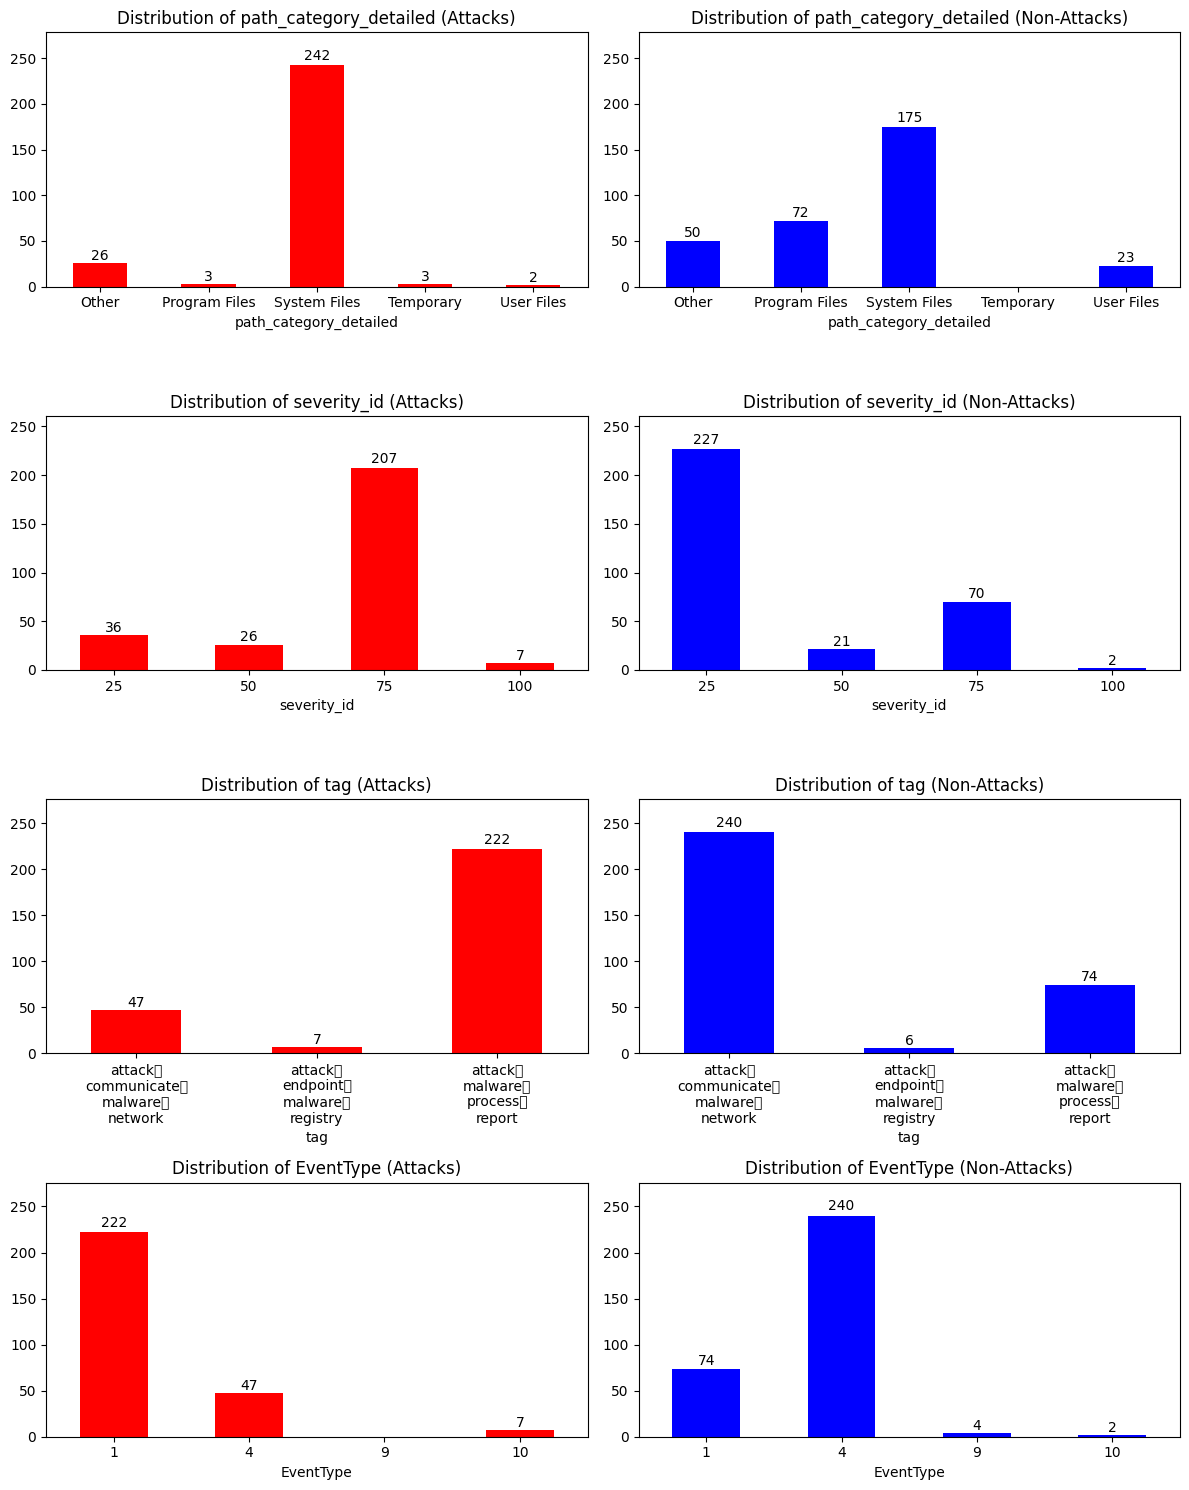

In [9]:
Plots.plot_distributions(result_df_Raw)

**Distribuzioni** di **attacchi** e **non-attacchi** per le colonne *path_category_detailed, severity_id, tag e EventType*.

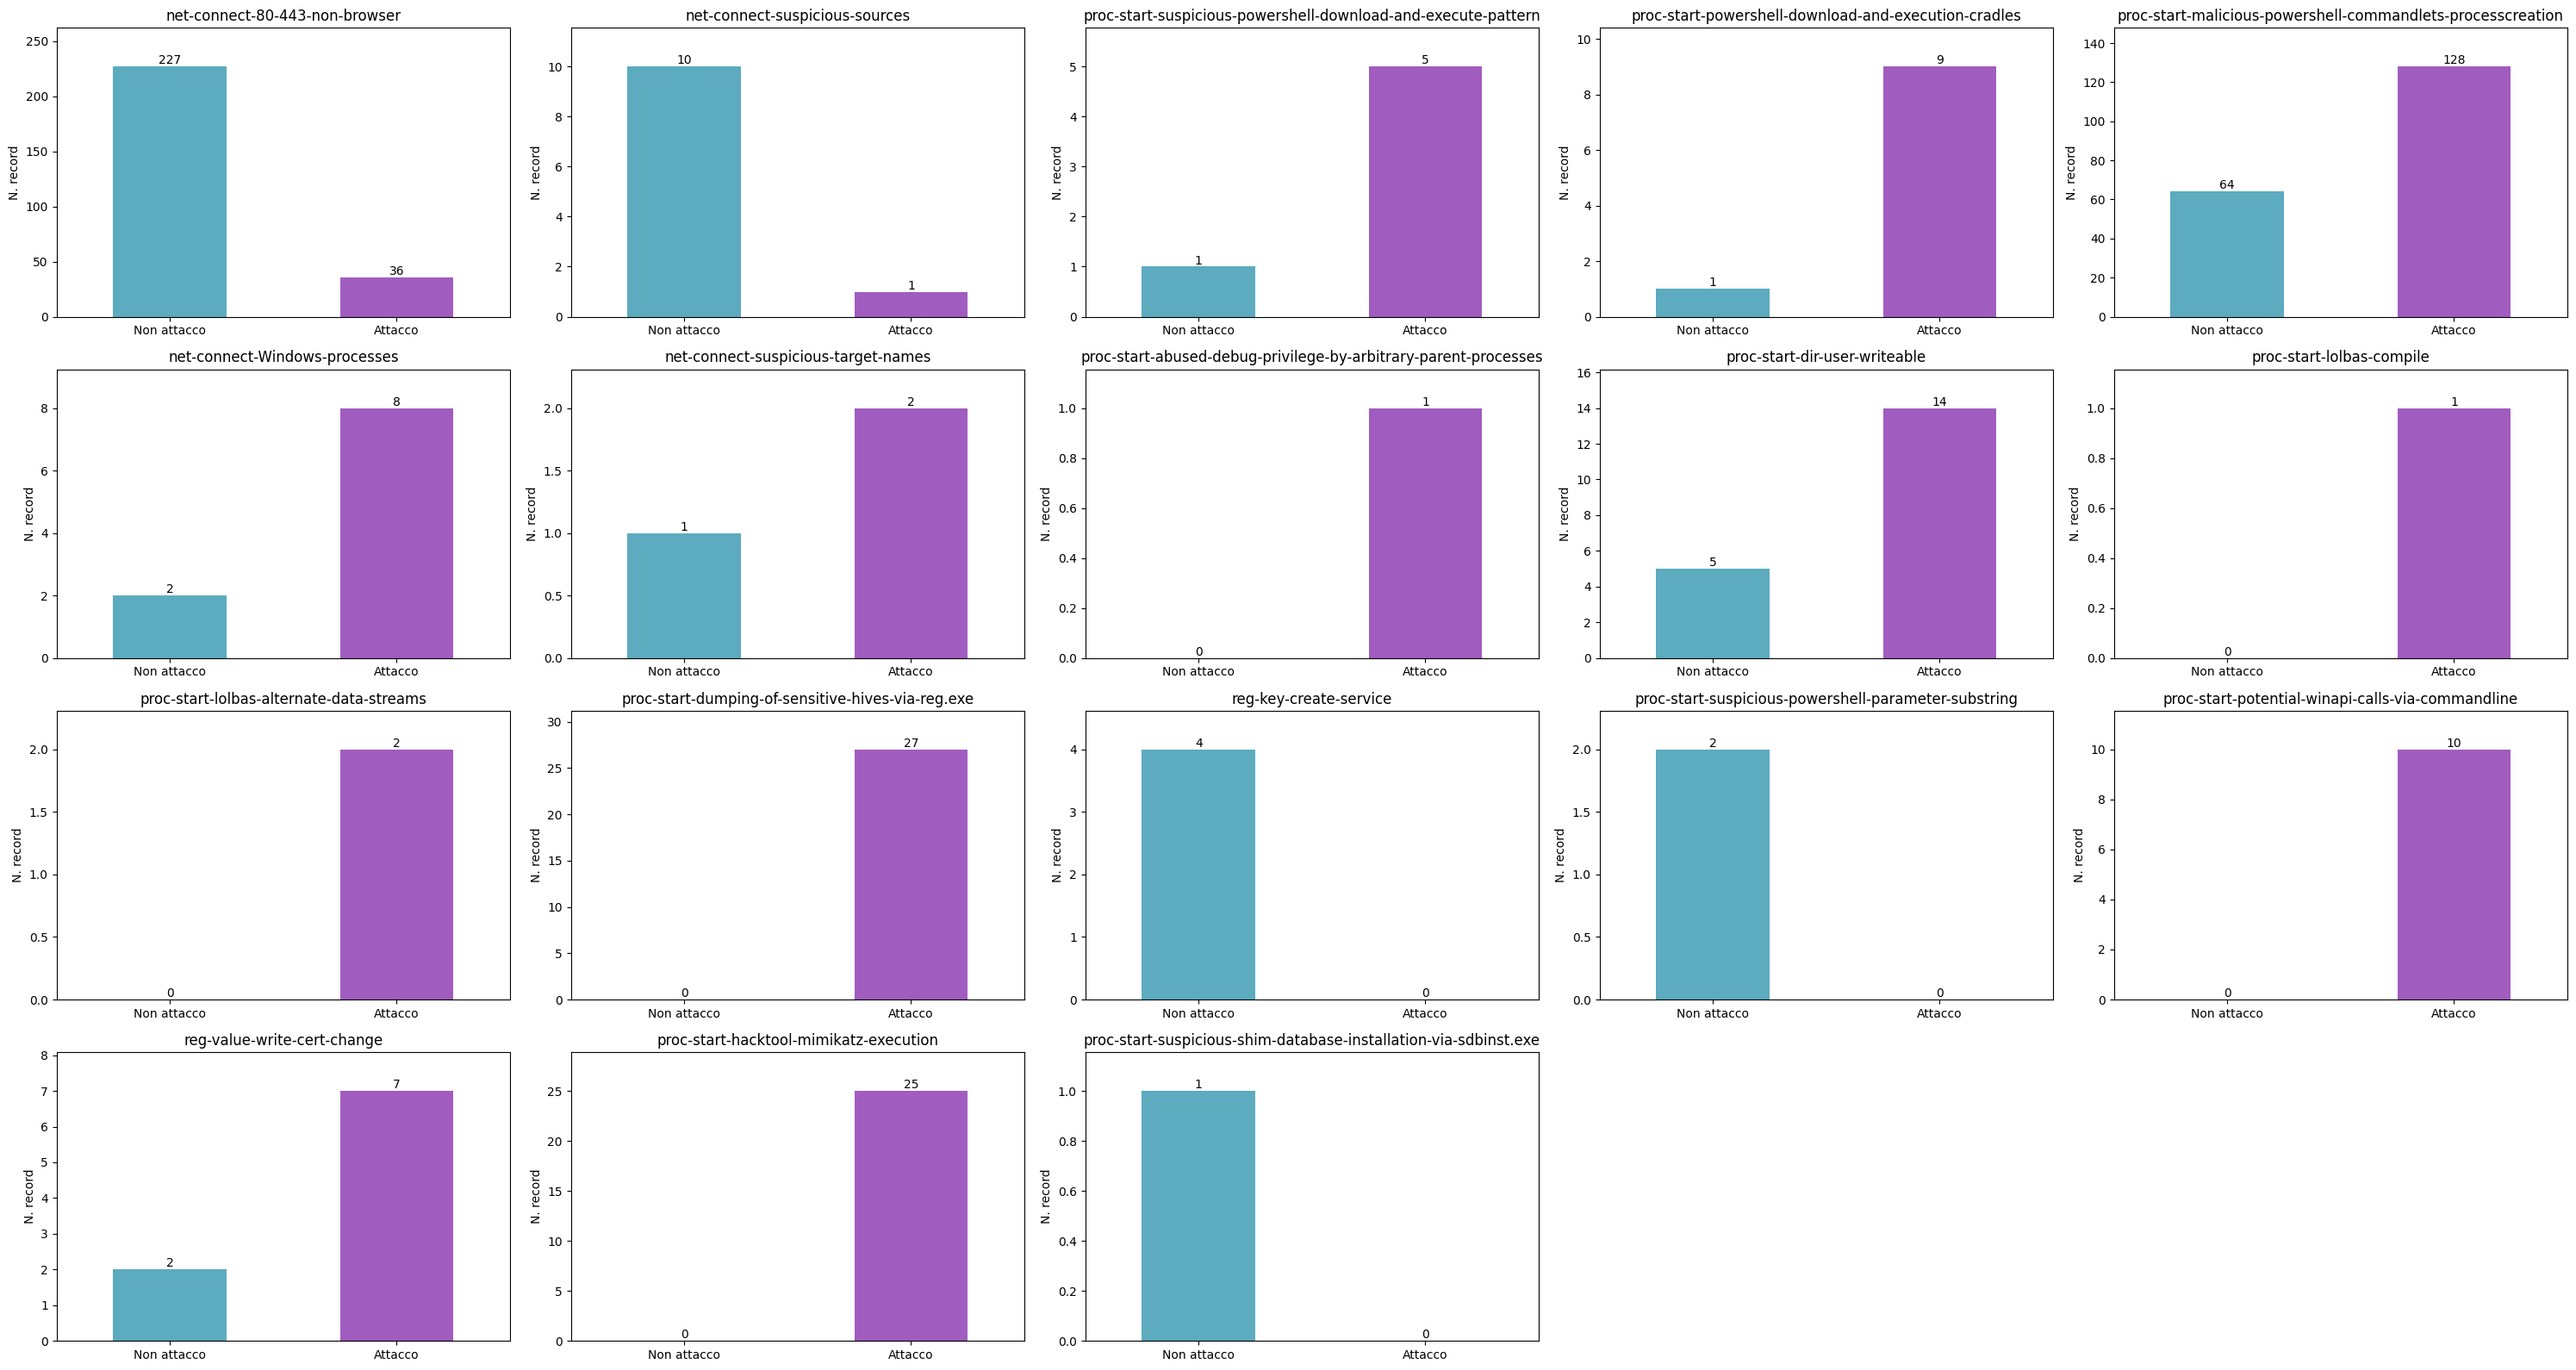

<h5>Grazie a questo grafico invece possiamo giungere ad una serie di conclusioni.

Su **18** regole diverse:

- quelle scattate in risposta ad ALMENO un **attacco reale** sono **15**.
  Di queste:
  - **2** si sono attivate più volte per **non-attacchi** rispetto che per gli attacchi. (*regole generiche*)
  - **0** si sono attivate lo **stesso numero** di volte per attacchi e non-attacchi.
  - **13** si sono attivate più volte in risposta ad **attacchi** rispetto che a non-attacchi (*regole specifiche*).

- quelle scattate **senza rispondere mai ad attacchi** sono **3**.

  **Si tratta di**: ['reg-key-create-service', 'proc-start-suspicious-powershell-parameter-substring', 'proc-start-suspicious-shim-database-installation-via-sdbinst.exe']</h5>

In [10]:
Plots.plot_value_counts_per_unique(result_df_Raw)

variables = MarkdownHelper.create_value_counts_variables(result_df_Raw)
MarkdownHelper.display_value_counts_text(variables)

# Analysis of Severity per Attacks

In [11]:
event_df = RunLogParser.create_event_df(attack_log_path, result_df_Raw)

Creazione del df **event_df** con le nuove colonne *severity_max, _min, _mean*

## Grafici

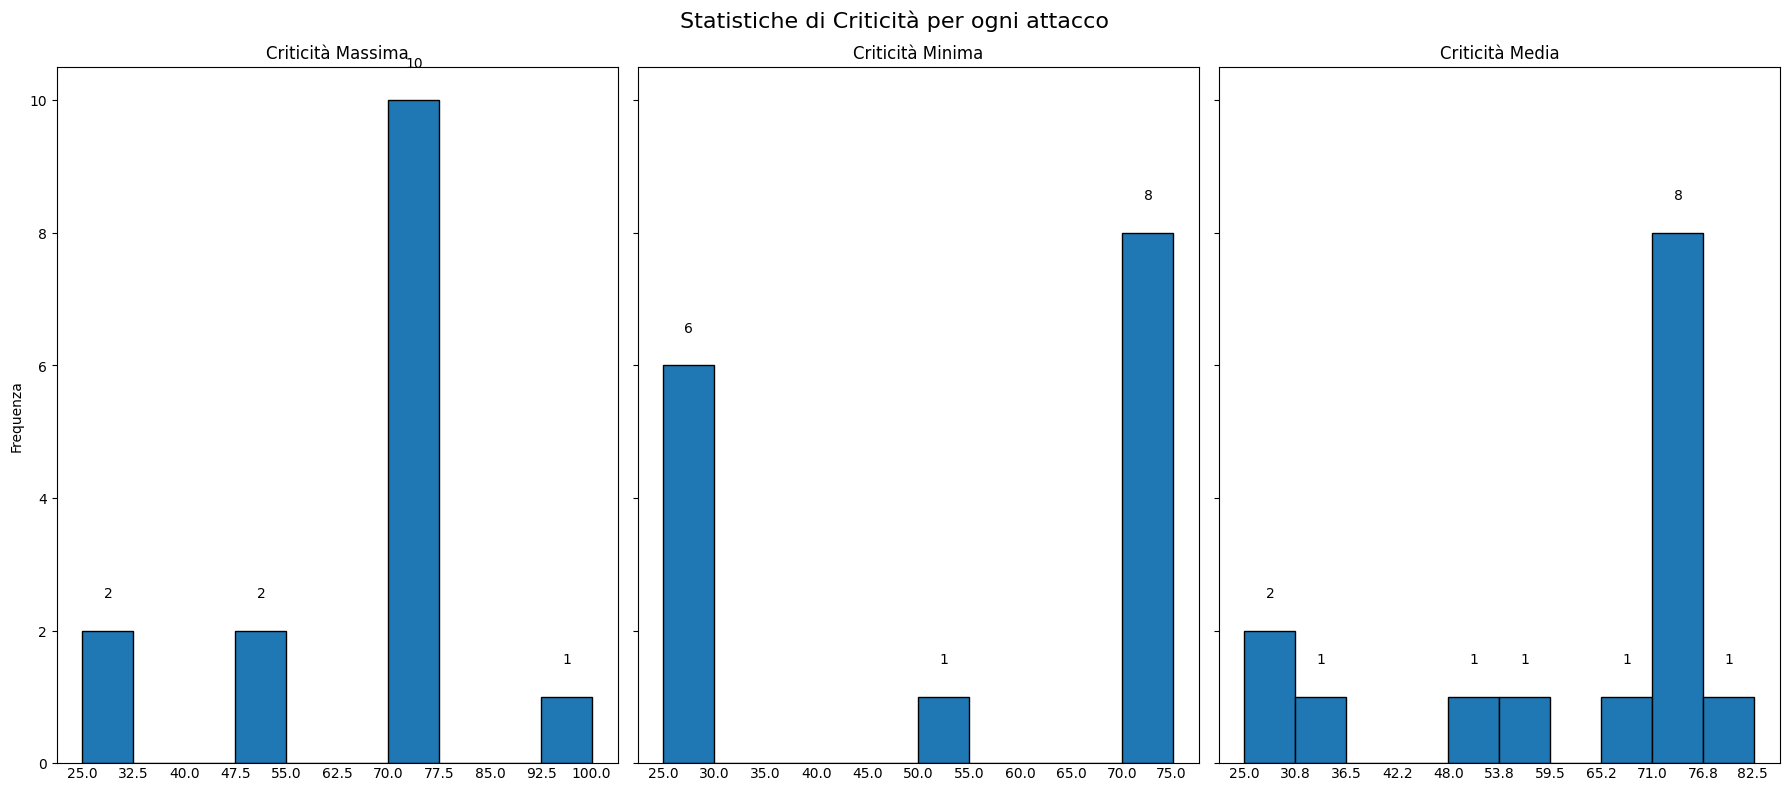

In [12]:
StatSeverity.plot_stat_severity(event_df)

In questo grafico vediamo, per **ciascun attacco** presente nel dataset, quali sono le loro **criticità** *massime, minime e medie*.

In [13]:
analyzer = AttackPatternAnalyzer(event_df)

In [14]:
# SCEGLIERE UN VALORE PER LA SEVERITY DELLE REGOLE DA CONSIDERARE
severity_value=73

# SCEGLIERE IL NUMERO DI ATTACCHI DA CONSIDERARE PRIMA DELLE REGOLE AVENTI LA SEVERITY SCELTA
num_attacks=10

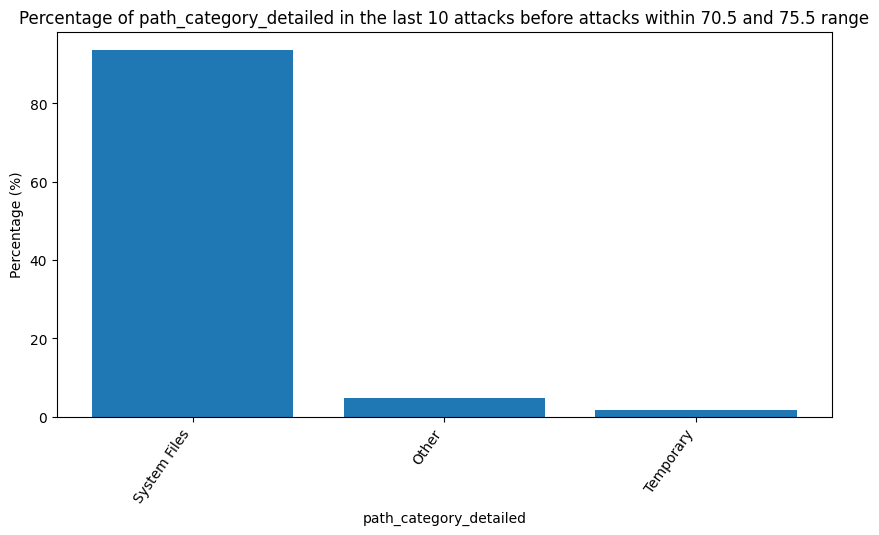

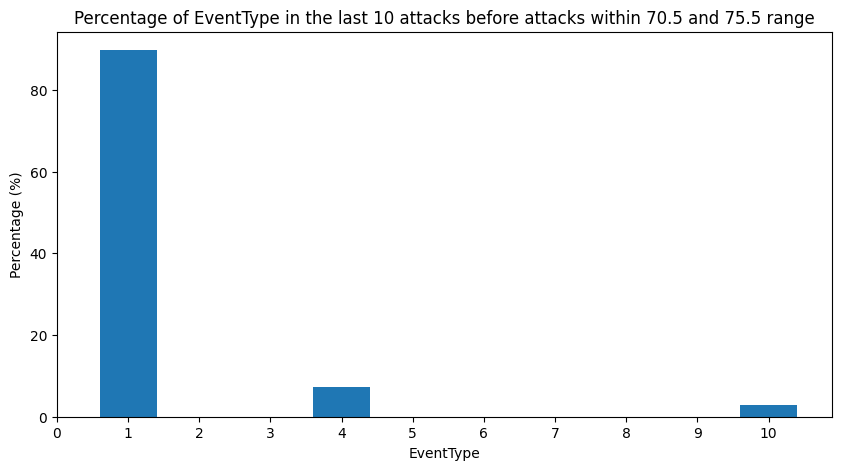

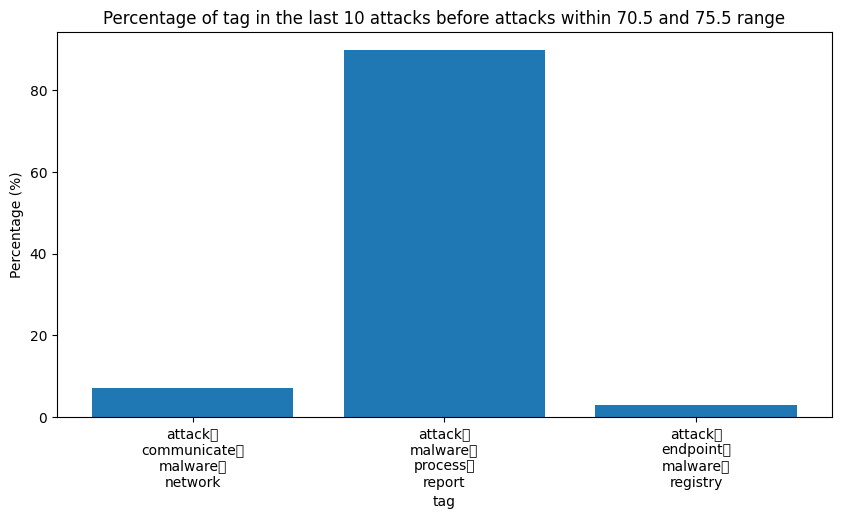

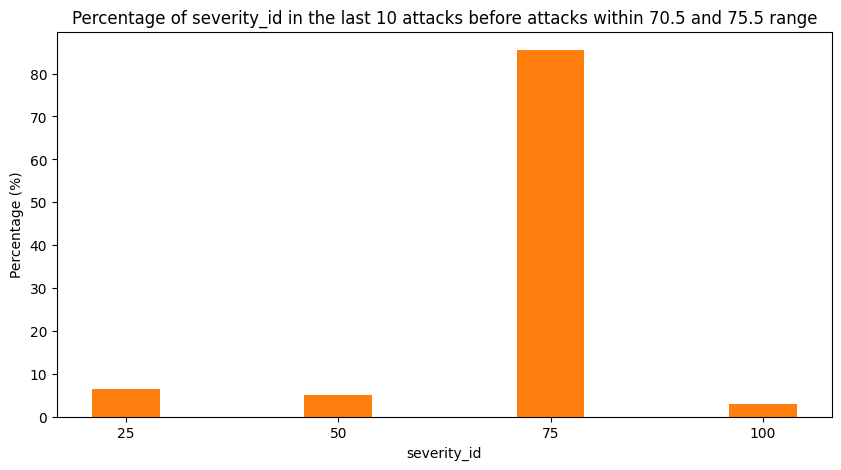

In [15]:
analyzer.pattern_before_attack(num_attacks=num_attacks, severity_value=severity_value)

In questi grafici prendiamo in considerazione gli **attacchi precedenti** a *tutti gli attacchi* che hanno una **certa criticità media** e *visualizziamo* tutti i valori di "**RuleAnnotation.mitre_attack.id**", "**signature**", "**EventType**", "**tag**", "**severity_id**" corrispondenti.

Per scegliere **quanti attacchi prima** *di quelli che ci interessano* vogliamo considerare basta modificare la variabile "**num_attacks**" e assegnarle il numero che vogliamo,  
mentre per scegliere il **valore della criticità media** che ci interessa si deve modificare la variabile "**severity_value**".  
Verranno presi in considerazione tutti gli attacchi con *criticità media compresa* tra **2.5 prima** e **2.5 dopo** del valore assegnato a "severity_value".

## Robustezza regole

In [16]:
signature_stats = SignatureStatsCalculator.create_signature_stats(event_df, result_df_Raw)
signature_stats

signature  Indice_Diff  \
0                      net-connect-80-443-non-browser     0.069137   
1                      net-connect-suspicious-sources     0.000000   
2   proc-start-suspicious-powershell-download-and-...     0.014830   
3   proc-start-powershell-download-and-execution-c...     0.019763   
4   proc-start-malicious-powershell-commandlets-pr...     0.013939   
5                       net-connect-Windows-processes     0.000829   
6                 net-connect-suspicious-target-names     0.000000   
7   proc-start-abused-debug-privilege-by-arbitrary...     0.000000   
8                       proc-start-dir-user-writeable     0.030763   
9                           proc-start-lolbas-compile     0.005556   
10           proc-start-lolbas-alternate-data-streams     0.005556   
11  proc-start-dumping-of-sensitive-hives-via-reg.exe     0.005399   
12                             reg-key-create-service     0.000000   
13  proc-start-suspicious-powershell-parameter-sub...     0.000000   
14  proc-start-potential-winapi-calls-via-commandline     0.000000   
15                        reg-value-write-cert-change     0.016625   
16             proc-start-hacktool-mimikatz-execution     0.000000   
17  proc-start-suspicious-shim-database-installati...     0.000000   

    Media_Differenza_Severity_min  Media_Differenza_Severity_mean  \
0                       -9.615385                       -3.271195   
1                        0.000000                        0.000000   
2                        0.000000                        0.565954   
3                        0.000000                        0.707442   
4                        0.000000                        0.000000   
5                        0.000000                       -0.040107   
6                        0.000000                        0.000000   
7                        0.000000                        0.000000   
8                        0.000000                       -0.068832   
9                        0.000000                        0.000000   
10                       0.000000                        0.000000   
11                       0.000000                        1.323529   
12                       0.000000                        0.000000   
13                       0.000000                        0.000000   
14                       0.000000                        0.000000   
15                       0.000000                        2.722222   
16                       0.000000                        0.000000   
17                       0.000000                        0.000000   

    Media_Differenza_Severity_max  N_Max_Sev_Diff_15  N_Attacchi_Non_rilevati  
0                        0.000000                  0                        2  
1                        0.000000                  0                        0  
2                        0.000000                  0                        0  
3                        0.000000                  0                        3  
4                        0.000000                  0                        0  
5                        0.000000                  0                        0  
6                        0.000000                  0                        0  
7                        0.000000                  0                        0  
8                        1.666667                  1                        0  
9                        0.000000                  0                        0  
10                       0.000000                  0                        0  
11                       0.000000                  0                        0  
12                       0.000000                  0                        0  
13                       0.000000                  0                        0  
14                       0.000000                  0                        2  
15                       3.333333                  1                        0  
16                       0.000000        

**signature_stats** è un dataset in cui possiamo vedere per **ogni regola** se venisse **rimossa** *quali cambiamenti* di **severity** apporterebbe al *dataset dei log* e se ci dovessero essere degli **attacchi** che **non** vengono **rilevati**.

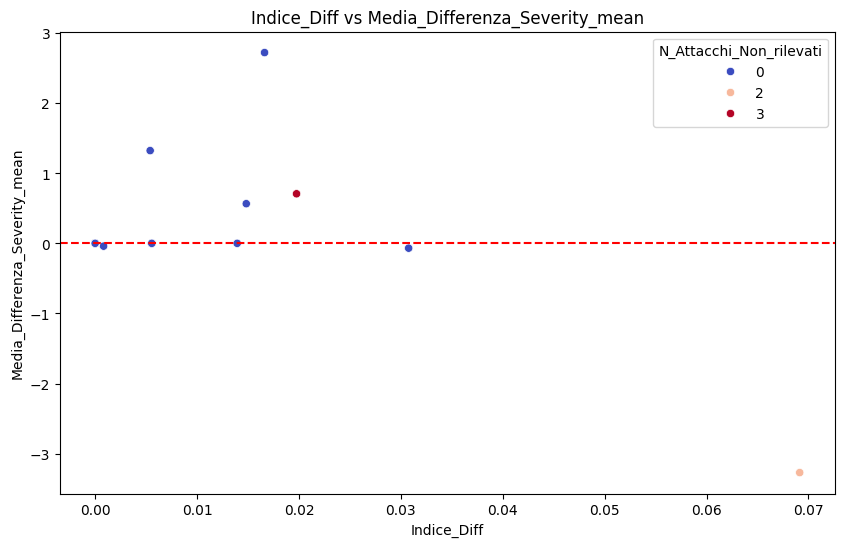

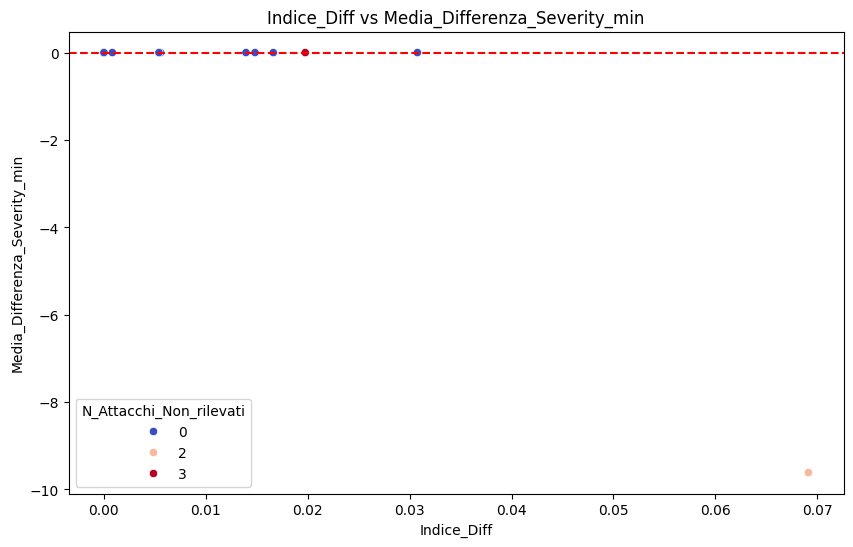

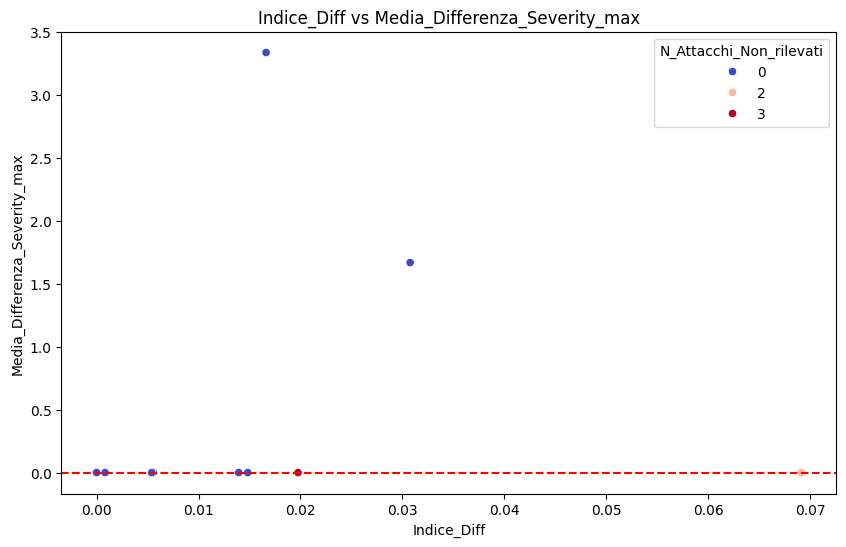

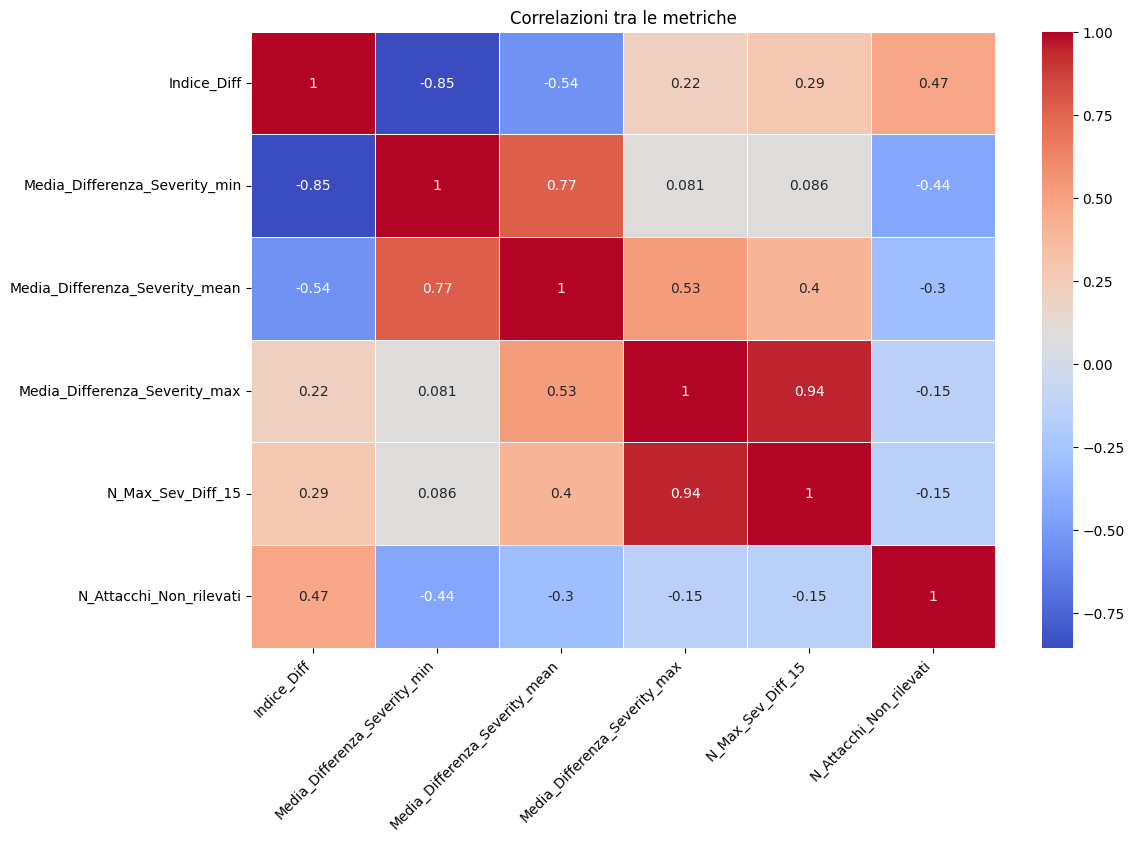

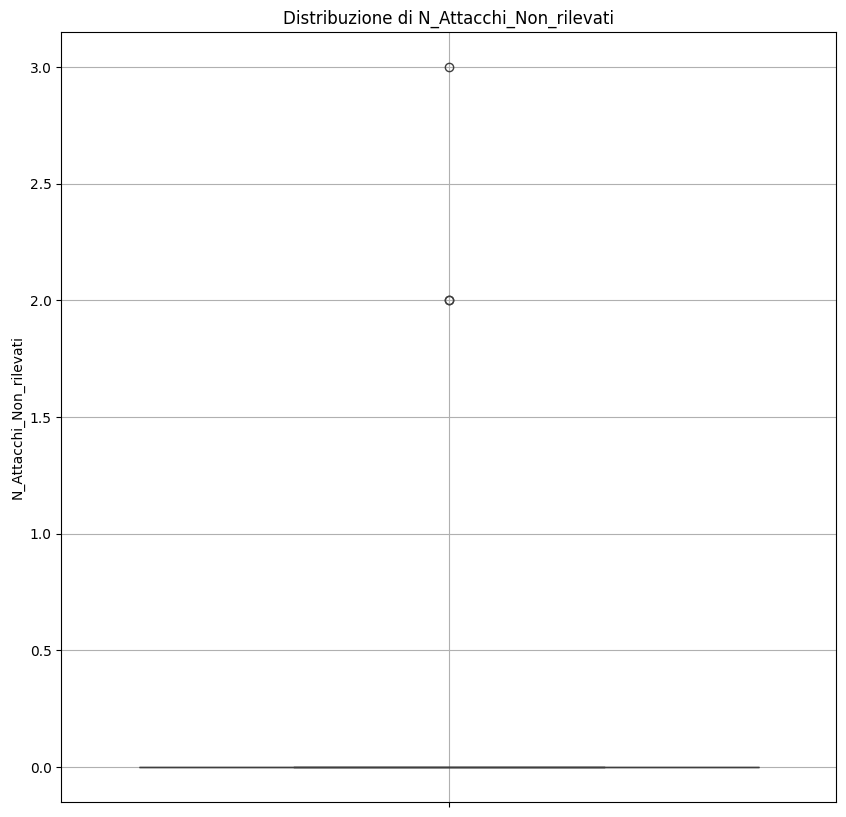

In [17]:
analysis = SigmaRuleAnalysis(signature_stats)
analysis.plots_sigma_rule_analysis()

# Graphic Analysis of Attacks for Chosen Rule

In [18]:
# SCEGLIERE LA REGOLA CHE SI VUOLE ANALIZZARE
regola_scelta = 'net-connect-80-443-non-browser'

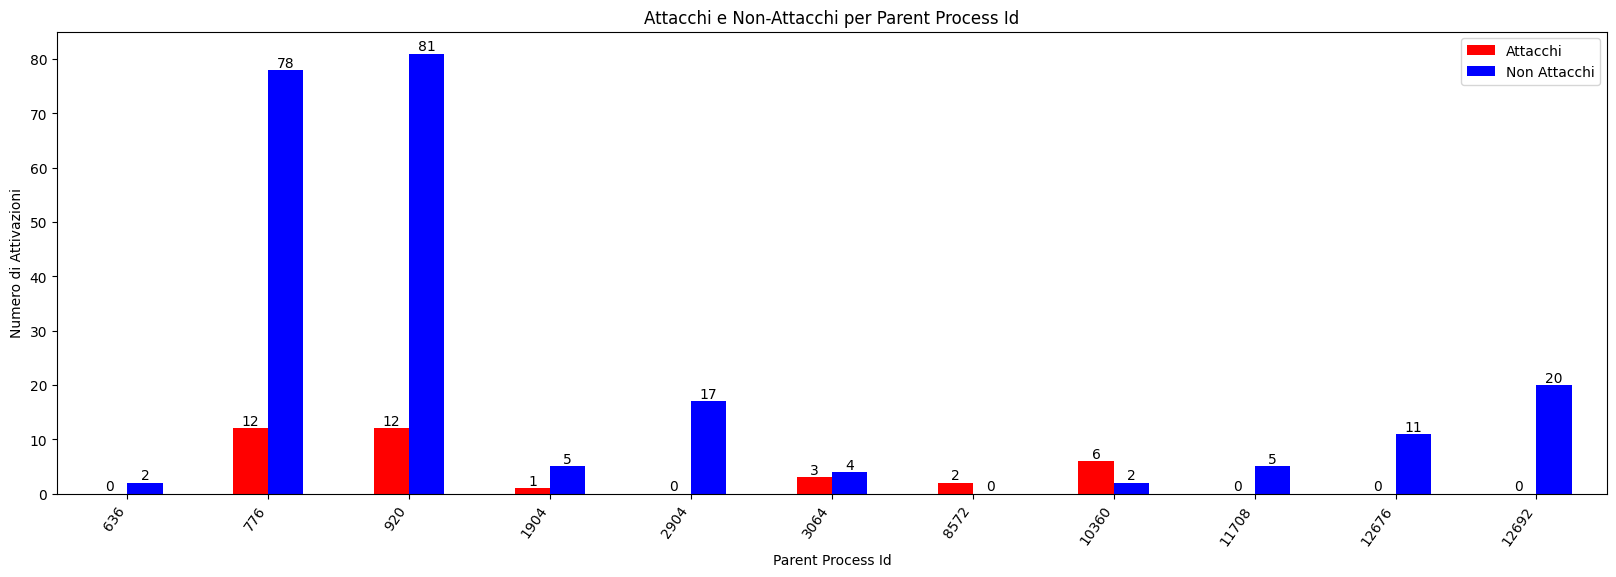

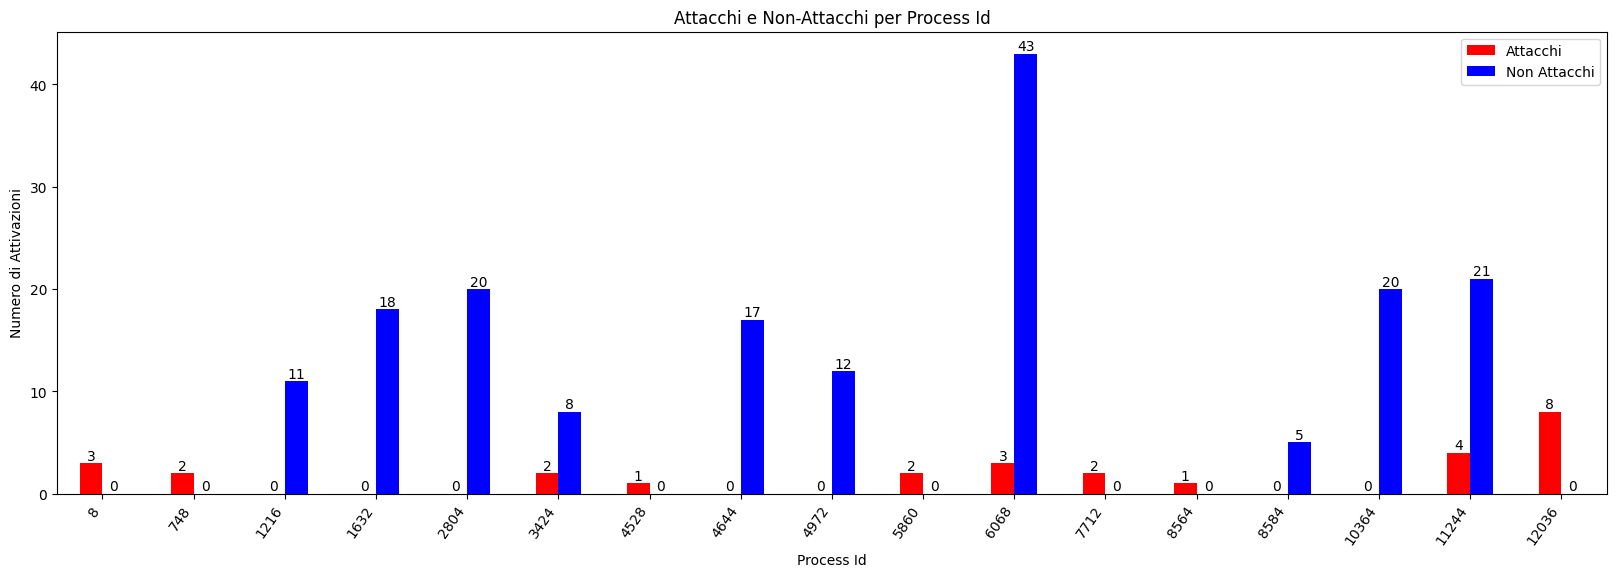

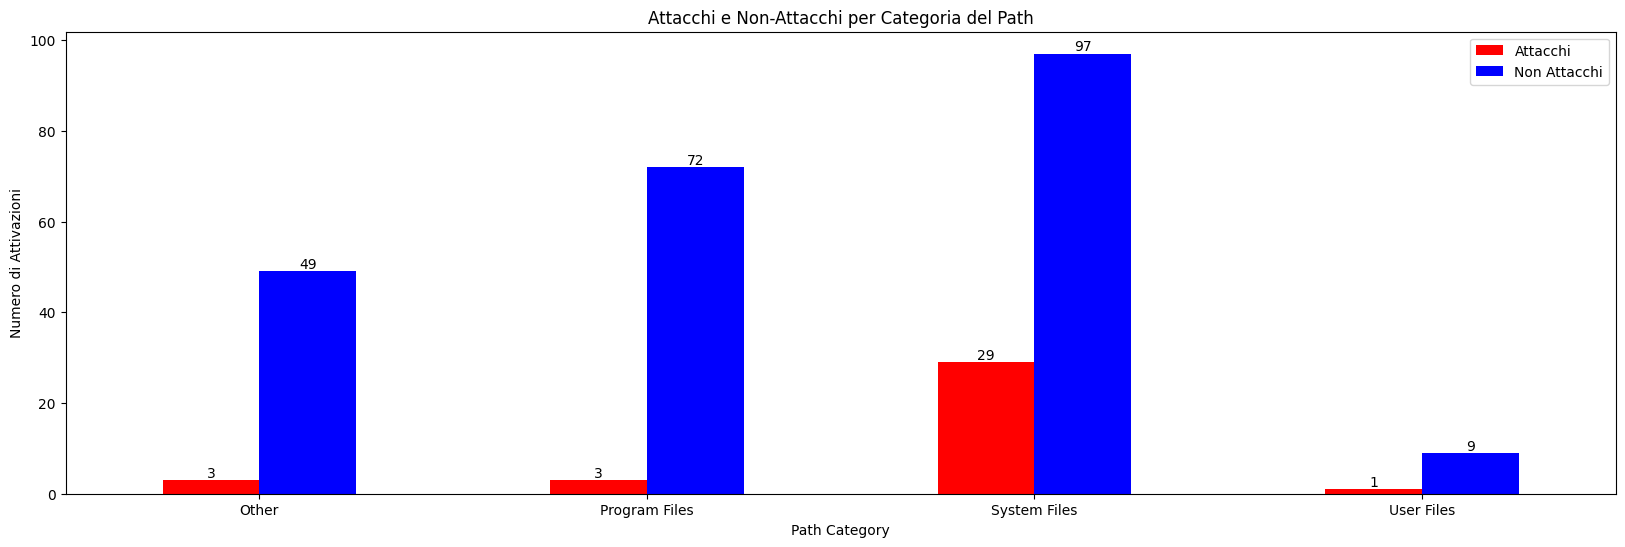

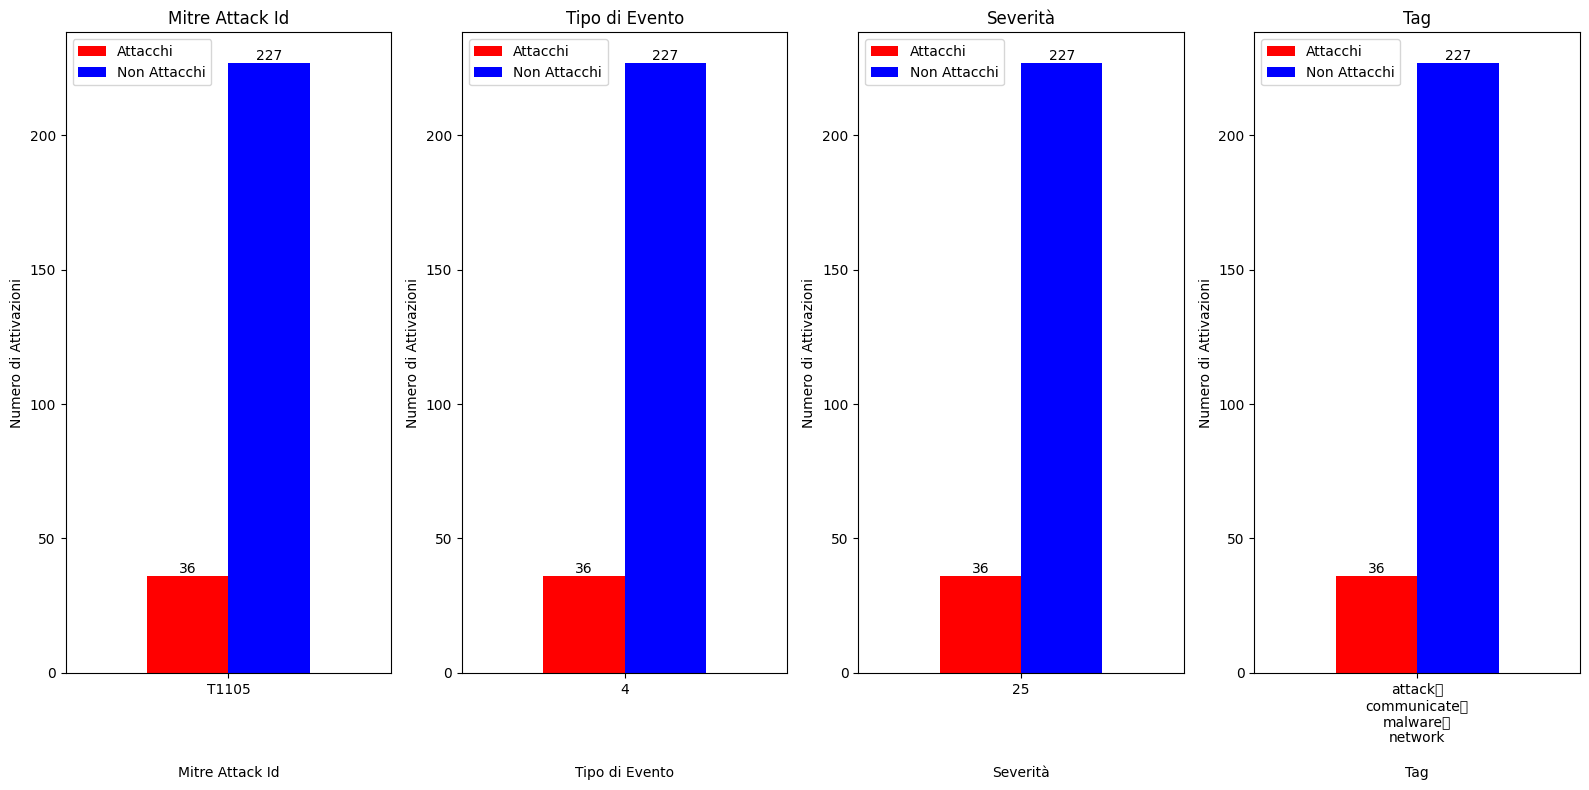

In [19]:
PlotsSingleAttack.analyze_rule_activations(result_df_Raw, regola_scelta)

In questi grafici in base alla **regola che si vuole analizzare** possiamo visualizzare:
- la **frequenza delle attivazioni** delle regole (attacchi e non attacchi) suddivise in intervalli di *5 minuti*;
- gli **attacchi e i non-attacchi** in base a:
    - *RuleAnnotation.mitre_attack.id*
    - *EventType*,
    - *severity*,
    - *tag*
    - *parent_process_id*,
    - *process_id*

In [20]:
# SCEGLIERE IL NUMERO DI EVENTI PRECEDENTI ALLA REGOLA CHE SI VOGLIONO ANALIZZARE
eventi_da_considerare = 5

alt.Chart(...)

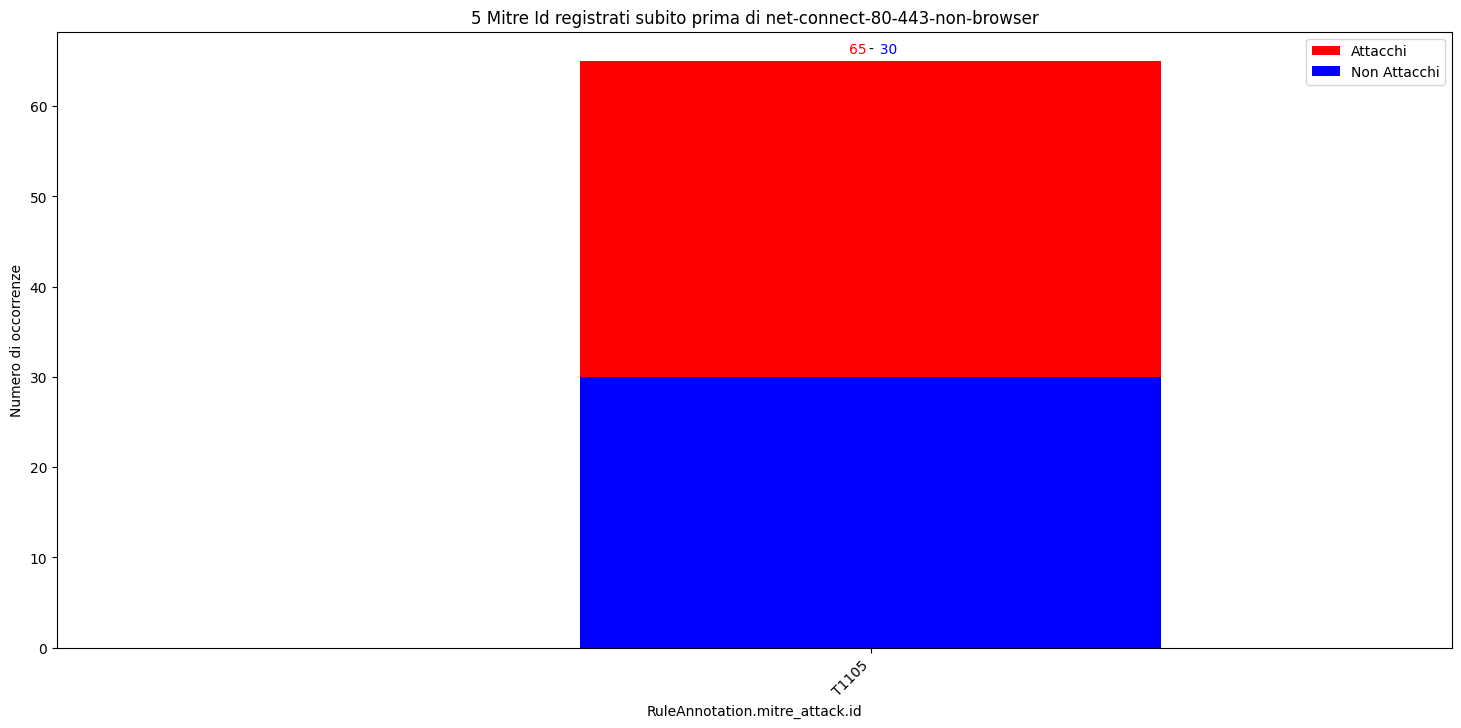

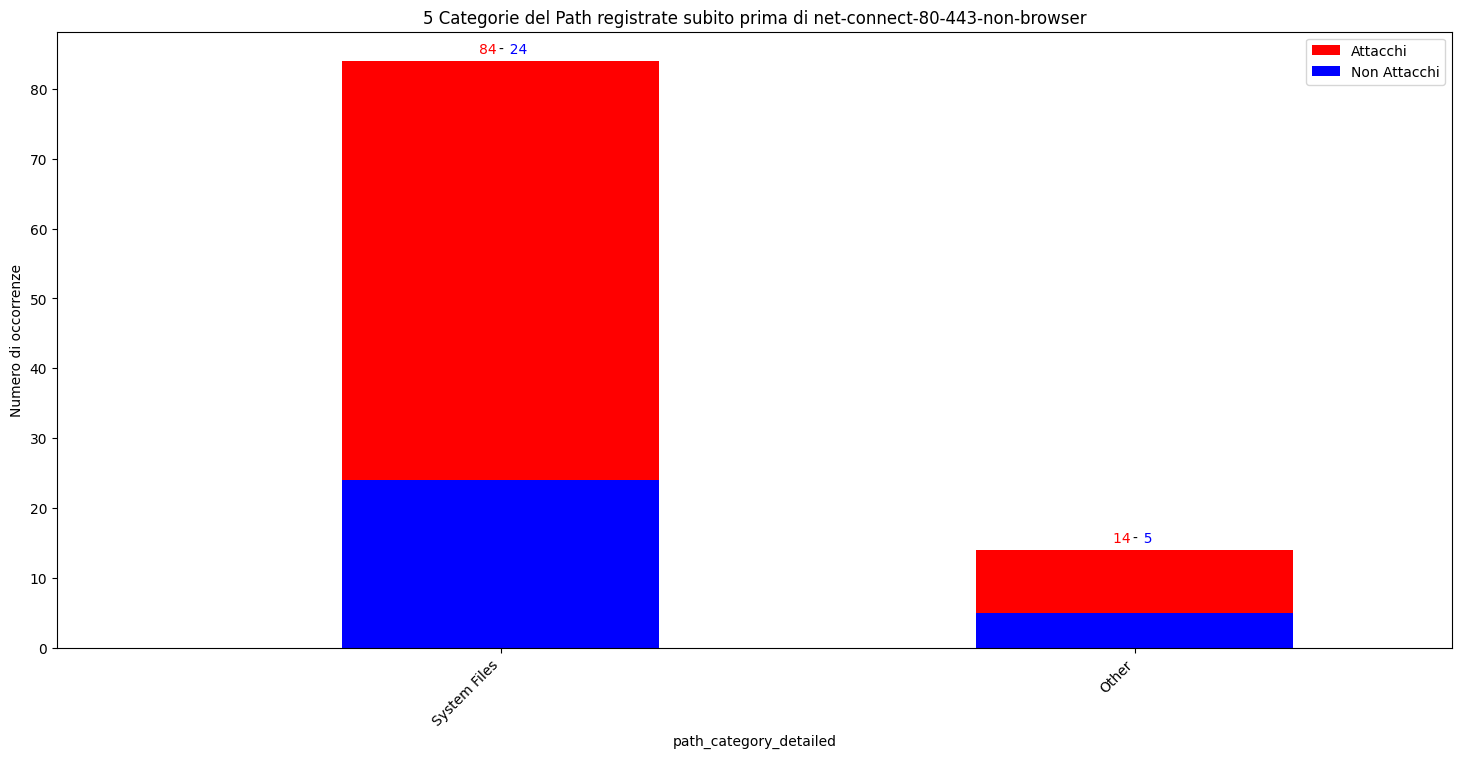

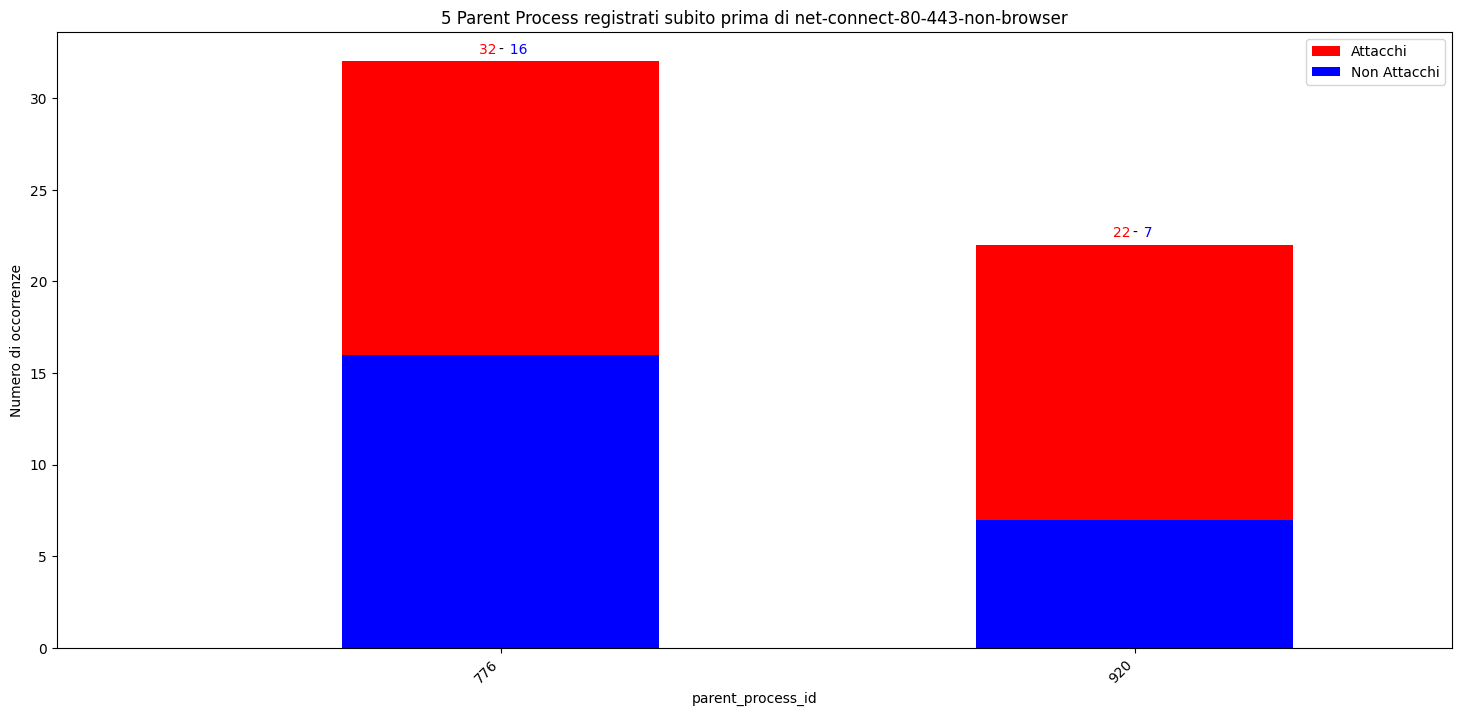

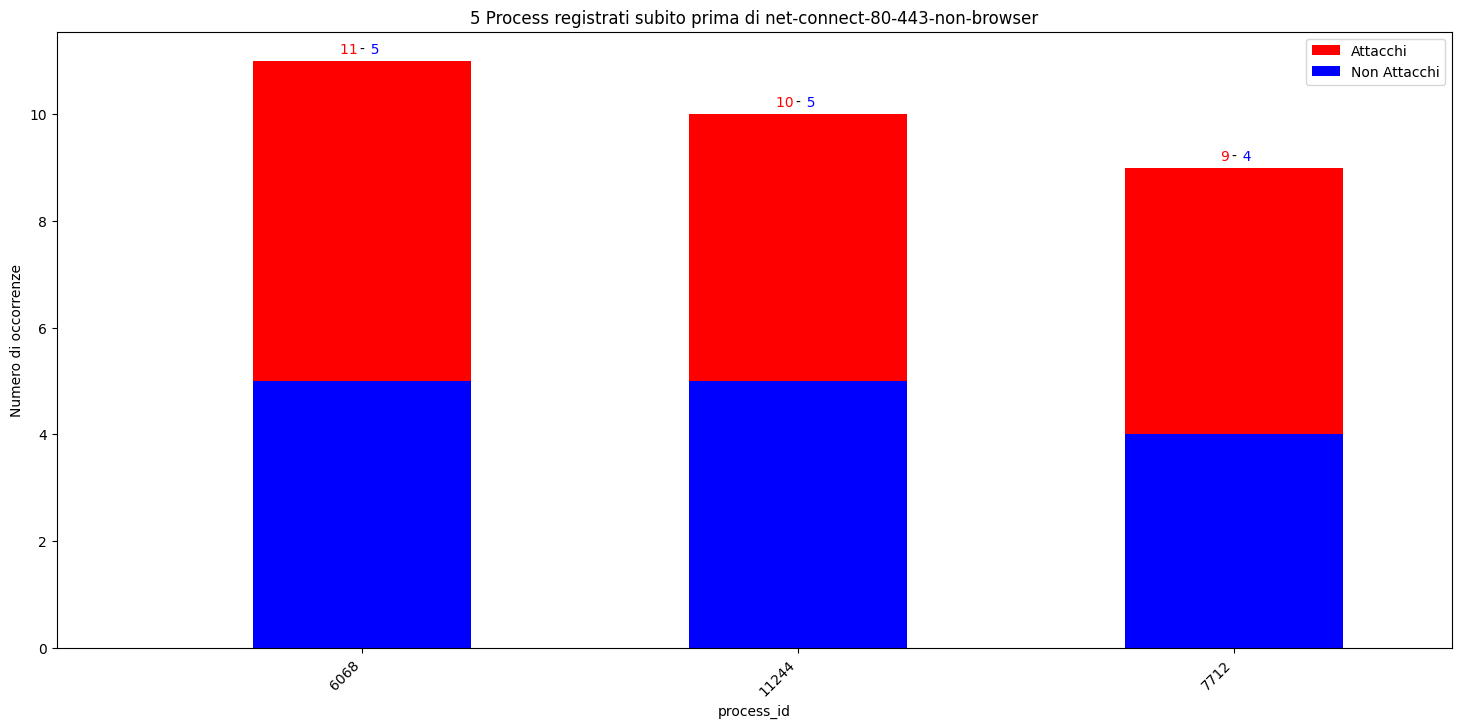

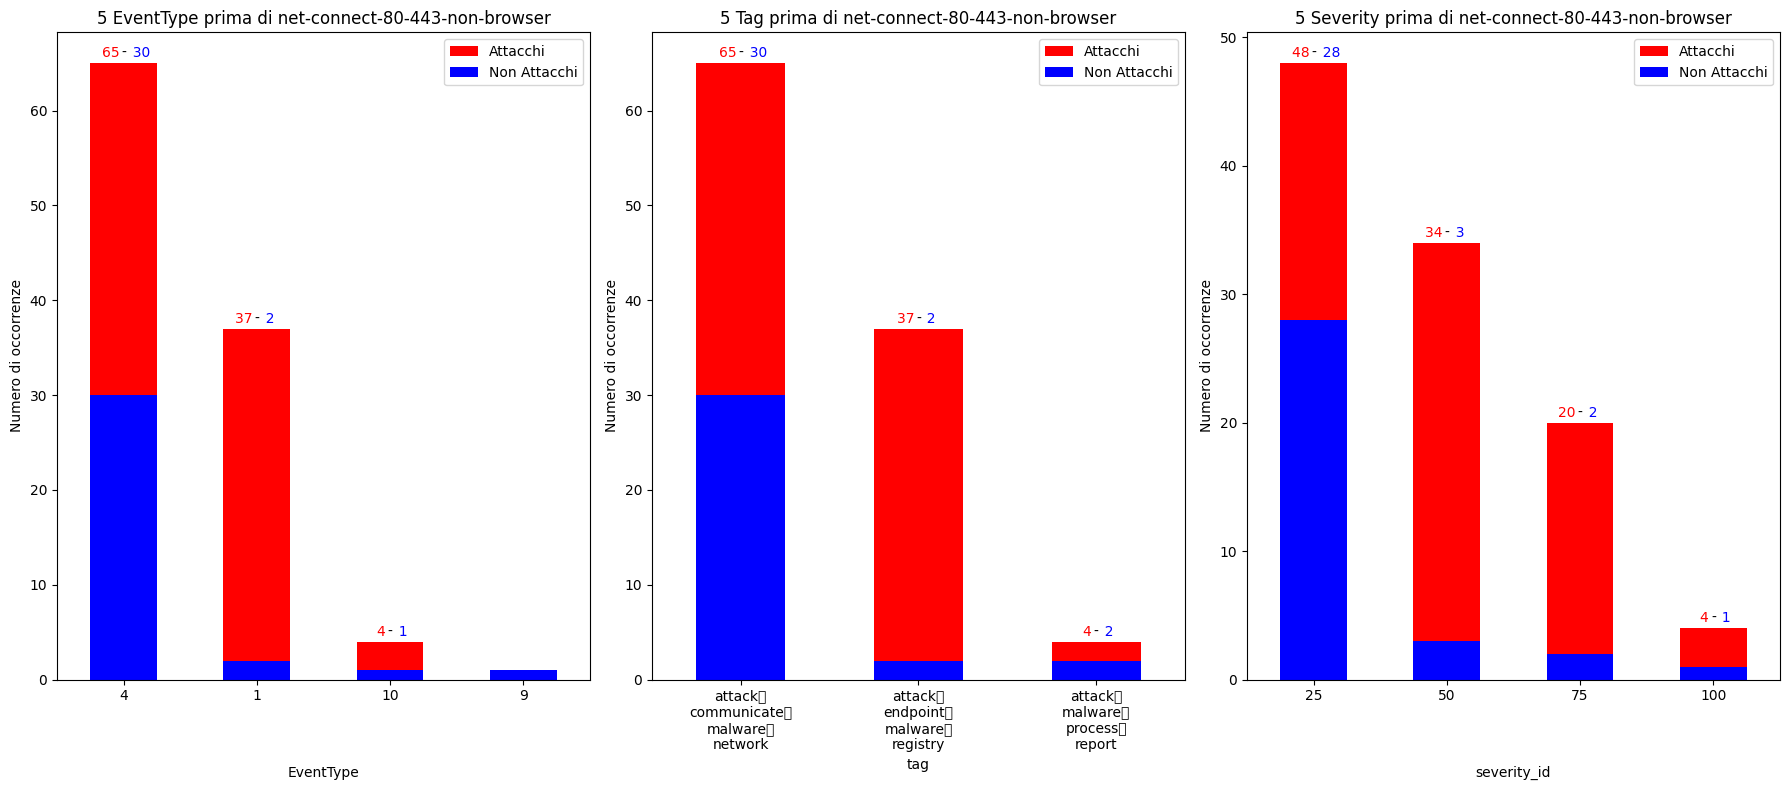

In [21]:
PlotsSingleAttack.patterns_before_activation(result_df_Raw, regola_scelta, eventi_da_considerare)

In questi grafici vediamo quali sono rispettivamente le *regole*, gli *attacchi*, gli *EventType*, i *tag*, i *parent_process*, i *process* e le *severity* degli eventi **subito prima** delle **prime attivazioni** della *regola scelta*.  
Il **numero di eventi da considerare** lo scegliamo affidando alla variabile *elementi_da_considerare* il numero che vogliamo.

Con "**prima attivazione di una regola**" si intende quando **almeno un elemento** delle colonne *signature, RuleAnnotation.mitre_attack.id, EventType, tag, severity_id, parent_process_id o process_id* (non sono considerate solo le colonne _time e corrisponde_ad_attacco) *di un evento* **differisce** da quello *precedente*.

# Patterns

In [22]:
signature_patterns = SignaturePatterns.recognize_signatures_patterns(result_df_Raw)
signature_patterns

Pattern: ('proc-start-dumping-of-sensitive-hives-via-reg.exe', 'proc-start-dumping-of-sensitive-hives-via-reg.exe'), Frequenza: 26
Pattern: ('proc-start-dumping-of-sensitive-hives-via-reg.exe', 'proc-start-dumping-of-sensitive-hives-via-reg.exe', 'proc-start-dumping-of-sensitive-hives-via-reg.exe'), Frequenza: 25
Pattern: ('proc-start-dumping-of-sensitive-hives-via-reg.exe', 'proc-start-dumping-of-sensitive-hives-via-reg.exe', 'proc-start-dumping-of-sensitive-hives-via-reg.exe', 'proc-start-dumping-of-sensitive-hives-via-reg.exe'), Frequenza: 24
Pattern: ('proc-start-hacktool-mimikatz-execution', 'proc-start-hacktool-mimikatz-execution'), Frequenza: 24
Pattern: ('proc-start-hacktool-mimikatz-execution', 'proc-start-hacktool-mimikatz-execution', 'proc-start-hacktool-mimikatz-execution'), Frequenza: 23
Pattern: ('proc-start-hacktool-mimikatz-execution', 'proc-start-hacktool-mimikatz-execution', 'proc-start-hacktool-mimikatz-execution', 'proc-start-hacktool-mimikatz-execution'), Frequenza

In `signature_patterns` vediamo le **sequenze di 3, 4 o 5 regole** in ordine da quella più a quella meno frequente **ripetutesi più volte** durante i vari *attacchi* e che **non compaiono mai** tra le sequenze di *falsi attacchi*

## With specified severity value

In [23]:
result_pattern_inside_attack = analyzer.pattern_inside_attack(severity_value=severity_value)
result_pattern_inside_attack

MITRE ATT&CK IDs:
1-digit repetitions:

2-digits sequences:
  ('T1059.001', 'T1059'): 1

3-digits sequences:
  ('T1059.001', 'T1059', 'T1482\r'): 2

SIGNATURES:
1-digit repetitions:

2-digits sequences:
  ('proc-start-suspicious-powershell-download-and-execute-pattern', 'proc-start-powershell-download-and-execution-cradles'): 1

3-digits sequences:
  ('proc-start-suspicious-powershell-download-and-execute-pattern', 'proc-start-powershell-download-and-execution-cradles', 'proc-start-malicious-powershell-commandlets-processcreation'): 2



In `result_pattern_inside_attack` vediamo:
- '**1-digit repetitions**' che corrisponde alle **ripetizioni** di *mitre_attack.id* e *signature* in testa agli attacchi con un numero **massimo di 3** mitre o signature registrati;
- '**2-digits sequences**' che corrisponde alle **sequenze** di *mitre_attack.id* e *signature* in testa agli attacchi con un numero di mitre o signature **compreso tra 4 e 5**;
- '**3-digits sequences**' che corrisponde alle **sequenze** di *mitre_attack.id* e *signature* in testa agli attacchi con un numero di mitre o signature **maggiore di 5** (non compreso).

# Correlation Matrix

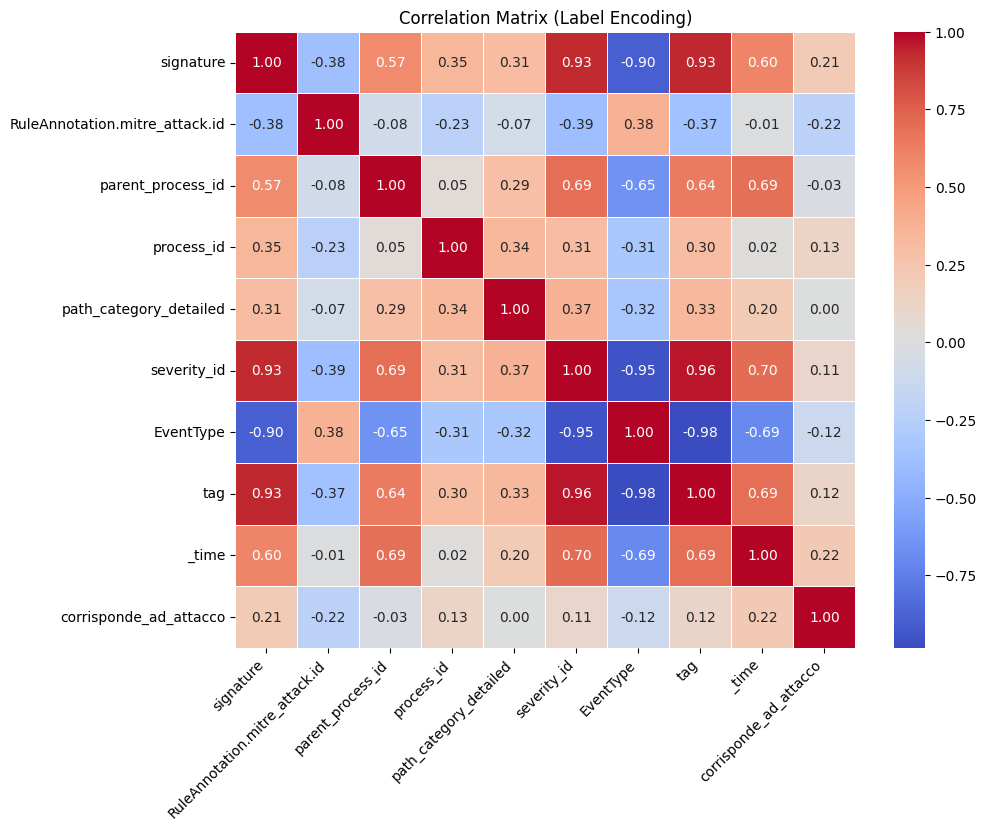

In [24]:
CorrelationMatrixPlots.plot_correlation_matrix(result_df_Le, 'Correlation Matrix (Label Encoding)')